## State based DID

$$y_{it} = \alpha + \beta_1 y_{it-1} + \beta_2 x_{it} + λ(α_1y_{it−1} −α_2x_{it−1}) + U_{it}\\ for i = 1, ..., N\\ t = 1, ..., T$$
$$y_{it} = \alpha  + \beta_2 x_{it}  + U_{it}\\ for i = 1, ..., N\\ t = 1, ..., T$$
where λ is the error correction towards the long-run relationship. Deviations from the cointegrated relationship are corrected through a series of short-run adjustments. In order to differentiate the impact of seasonal temperature by temperature clus- ter, we introduce a dummy for each temperature group. Mild countries are associated with the unit value of d1; Hot countries are represented by d2 and finally Cold countries are identified by d0. This is the reference group and therefore its dummy- related variables are not included in the regression.

Dummies differentiate the effects of temperature increases between groups through a group-specific intercept. To differentiate the effects on the slope, we interact all covariates with the dummies.
With these additional variables, the model reads as follows:



$$y_{it} = \sum \limits_{j=0,1,2}^{}\alpha_{ij}d_j + \sum\limits_{j=0,1,2}^{}\beta_{1j} \Delta y_{it-1}d_j + \sum\limits_{j=0,1,2}^{}\beta_{2j} \Delta x_{it}d_j + λ(\sum\limits_{j=0,1,2}^{}\gamma_1y_{it−1}d_j −\sum\limits_{j=0,1,2}^{}\gamma_2x_{it−1}d_j) + v_{it}\\where j=0,1,2\\0=Cold,1=Mild,2=Hot.$$


#### table to convert F to C


   |details.       | F.        |C|
   |-------------- |---------- |---|
   |Absolute Zero	|-459.67°F	|-273.15°C|
   |Parity	|-40°F	|-40°C|
   |Zero	|0°F	|-17.78°C|
   |Freezing point	|32°F	|0°C|
   |Body Temperature	|98.6°F	|37°C|
   |Boiling point	|212°F	|100°C|

#### comments by Harry

- split the data between residential and commercial, and run two models
- don't just look at avg temps use all the avg month data you have.



In [5]:
# importing libraries
import numpy as np
import pandas as pd
import xgboost as xgb
#import catboost as cb
#import lightgbm as lgb
import matplotlib.pyplot as plt

from copy import deepcopy
from collections import defaultdict

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, LeaveOneGroupOut

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# loading in DATA
train_df = pd.read_csv('data/kaggle/train.csv')
train_df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


## creating subsets of dataset
States are assorted into groups based on average temperatures,

As seen below through the code mid states are 2,5,11, cold = 4,8 and hot 1,10

another interesting observation is that the std for 1 and 4 is greater than the rest of the states.

#### Analysis to group according to temperatures. 

In [6]:
Montemperaturedat = train_df.loc[:,'january_min_temp':'december_max_temp']
avgmontemp = Montemperaturedat.filter(like='avg')
names = list(avgmontemp.columns)
Montemperaturedat.to_pic

<AxesSubplot:xlabel='State_Factor'>

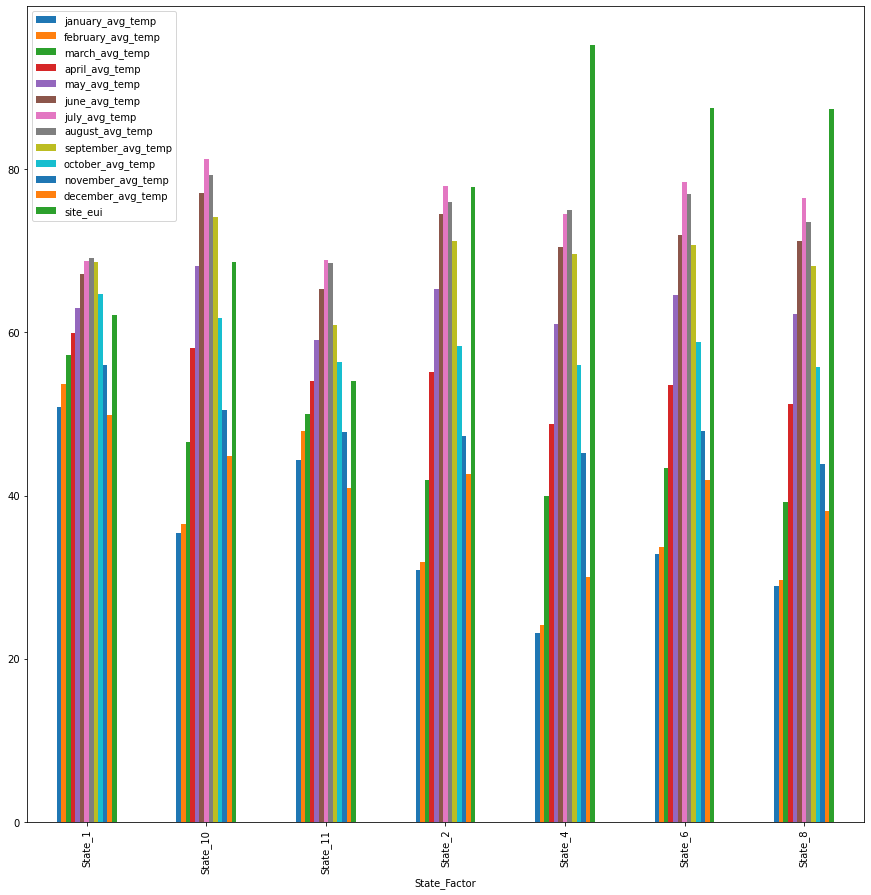

In [25]:
plt.rcParams['figure.figsize'] = [15, 15]
monthlyAvglist = names+['site_eui']
train_df.groupby('State_Factor')[monthlyAvglist].mean().plot(kind='bar')

In [48]:
#state_wise distribution of the data
midStates = train_df[(train_df['State_Factor']=='State_2')|(train_df['State_Factor']=='State_5')|(train_df['State_Factor']=='State_11')]
colStates = train_df[(train_df['State_Factor']=='State_4')|(train_df['State_Factor']=='State_8')]
hotStates = train_df[(train_df['State_Factor']=='State_1')|(train_df['State_Factor']=='State_10')]

In [53]:
from statsmodels.formula.api import ols

fit = ols('site_eui ~ C(State_Factor) + C(facility_type)+C(year_built) + avg_temp', data=train_df).fit() 

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

In [54]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               site_eui   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     101.6
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        17:28:37   Log-Likelihood:            -3.9407e+05
No. Observations:               73920   AIC:                         7.886e+05
Df Residuals:                   73674   BIC:                         7.909e+05
Df Model:                         245                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        94.4292     22.315      4.232      0.000      50.693     138.166
C(State_Factor)[T.State_10]                                       7.8708     12.997      0.606      0.545     -17.604      33.345
C(State_Factor)[T.State_11]                                       4.4491      1.463      3.042      0.002       1.583       7.316
C(State_Factor)[T.State_2]                                       12.6311      1.282      9.850      0.000      10.118      15.144
C(State_Factor)[T.State_4]                                       17.4631      1.725     10.125      0.000      14.083      20.844
C(State_Factor)[T.State_6]                                       27.7093      1.083     25.592      0.000      25.587      29.831
C(State_Factor)[T.State_8]                                       14.4774      1.597      9.064      0.000      11.347      17.608
C(facility_type)[T.5plus_Unit_Building]                           6.9609      1.842      3.779      0.000       3.351      10.571
C(facility_type)[T.Commercial_Other]                             48.7752      1.848     26.394      0.000      45.153      52.397
C(facility_type)[T.Commercial_Unknown]                           83.5234      5.863     14.245      0.000      72.031      95.016
C(facility_type)[T.Data_Center]                                 294.9803      9.788     30.138      0.000     275.796     314.164
C(facility_type)[T.Education_College_or_university]              64.3573      2.201     29.238      0.000      60.043      68.672
C(facility_type)[T.Education_Other_classroom]                    22.6613      1.716     13.206      0.000      19.298      26.025
C(facility_type)[T.Education_Preschool_or_daycare]                4.8300      5.099      0.947      0.343      -5.164      14.824
C(facility_type)[T.Education_Uncategorized]                      40.6292      5.898      6.889      0.000      29.069      52.189
C(facility_type)[T.Food_Sales]                                   95.8065      6.349     15.090      0.000      83.363     108.250
C(facility_type)[T.Food_Service_Other]                           12.7702     12.295      1.039      0.299     -11.329      36.869
C(facility_type)[T.Food_Service_Restaurant_or_cafeteria]        172.6046      6.493     26.585      0.000     159.879     185.330
C(facility_type)[T.Food_Service_Uncategorized]                   88.5984     11.961      7.407      0.000      65.154     112.043
C(facility_type)[T.Grocery_store_or_food_market]                204.2281      2.815     72.548      0.000     198.711     209.746
C(facility_type)[T.Health_Care_Inpatient]                       199.9280      3.006     66.51

test
